In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from random import shuffle
from typing import Callable
import cv2
from PIL import Image
from torchsummary import summary
from torchviz import make_dot
import graphviz

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

plt.style.use("ggplot")

## Data Visualization

In [2]:
# display the content of the chest_xray folder
os.listdir(path="./chest_xray/")

['chest_xray', 'test', 'train', 'val', '__MACOSX']

In [3]:
# general paths of the x-rays data
TRAIN_DIR = "./chest_xray/train/"
VALIDATION_DIR = "./chest_xray/val/"
TEST_DIR = "./chest_xray/test/"

In [4]:
"""All functions will be written in this block"""
def get_number_of_images(path_to_folder:str):
    normal = len(os.listdir(path_to_folder + "NORMAL"))
    pneumonia = len(os.listdir(path_to_folder + "PNEUMONIA"))
    total = normal + pneumonia

    return normal, pneumonia, total

def display_number_samples(set:str, normal:int, pneumonia:int)->None:
    table_data = [
        ["NORMAL", normal],
        ["PNEUMONIA", pneumonia],
        ["TOTAL", normal + pneumonia]
    ]
    
    print(f"{set} set:\n")
    print(tabulate(table_data, headers=["Class", "Number of Samples"], tablefmt="pretty"))
    print("\n")

def plot_normal_pneumonia(normal, pneumonia, subset="whole", ax=None) -> None:
    categories = ["Normal", "Pneumonia"]
    counts = [normal, pneumonia]

    # Creating a bar plot using Seaborn
    sns.barplot(x=categories, y=counts, ax=ax)

    # Adding labels and title to the plot
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title(f'Distribution of Images in the {subset} Set')

    # Displaying the number of instances on the bars
    for i, count in enumerate(counts):
        plt.text(i, count + 10, str(count), ha='center', va='bottom', weight="bold")

    # Displaying the plot
    plt.show()

def plot_examples(path:str, folder="NORMAL/") -> None:
    fig = plt.figure(figsize=(16,5))
    fig.suptitle(f"{folder[:-1]}", size=22)

    img_paths = os.listdir(path+folder)
    shuffle(img_paths) 

    for i, image in enumerate(img_paths[:4]):
        img = cv2.imread(os.path.join(path+folder, image)) 
        plt.subplot(1, 4, i+1, frameon=False)
        plt.imshow(img)
        
    fig.show()

In [5]:
os.listdir(TRAIN_DIR)

['NORMAL', 'PNEUMONIA']

In [6]:
normal_train, pneumonia_train, total_train = get_number_of_images(path_to_folder=TRAIN_DIR)
normal_val, pneumonia_val, total_val = get_number_of_images(path_to_folder=VALIDATION_DIR)
normal_test, pneumonia_test, total_test = get_number_of_images(path_to_folder=TEST_DIR)

In [7]:
display_number_samples(set="TRAIN", normal=normal_train, pneumonia=pneumonia_train)
display_number_samples(set="VALIDATION", normal=normal_val, pneumonia=pneumonia_val)

TRAIN set:

+-----------+-------------------+
|   Class   | Number of Samples |
+-----------+-------------------+
|  NORMAL   |       1341        |
| PNEUMONIA |       3875        |
|   TOTAL   |       5216        |
+-----------+-------------------+


VALIDATION set:

+-----------+-------------------+
|   Class   | Number of Samples |
+-----------+-------------------+
|  NORMAL   |         8         |
| PNEUMONIA |         8         |
|   TOTAL   |        16         |
+-----------+-------------------+




In [8]:
display_number_samples(set="TEST", normal=normal_test, pneumonia=pneumonia_test)

TEST set:

+-----------+-------------------+
|   Class   | Number of Samples |
+-----------+-------------------+
|  NORMAL   |        234        |
| PNEUMONIA |        390        |
|   TOTAL   |        624        |
+-----------+-------------------+




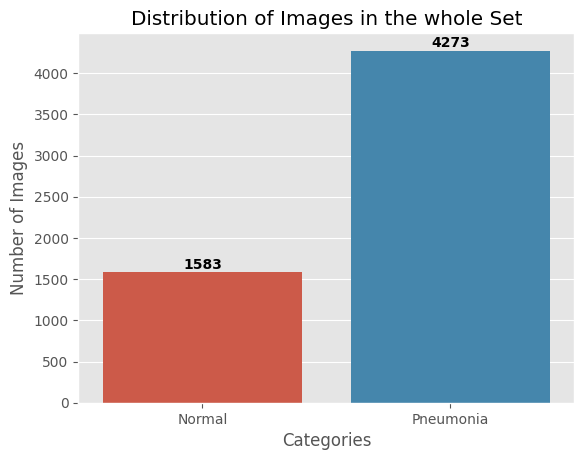

In [9]:
# Plotting the Test subset
plot_normal_pneumonia(normal=normal_test+normal_val+normal_train, 
                      pneumonia=pneumonia_test+pneumonia_val+pneumonia_train)

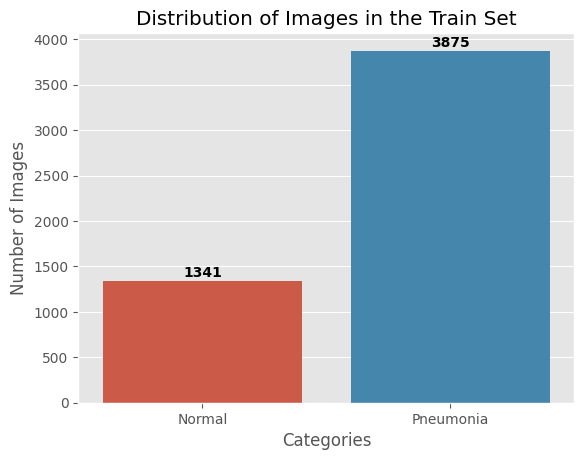

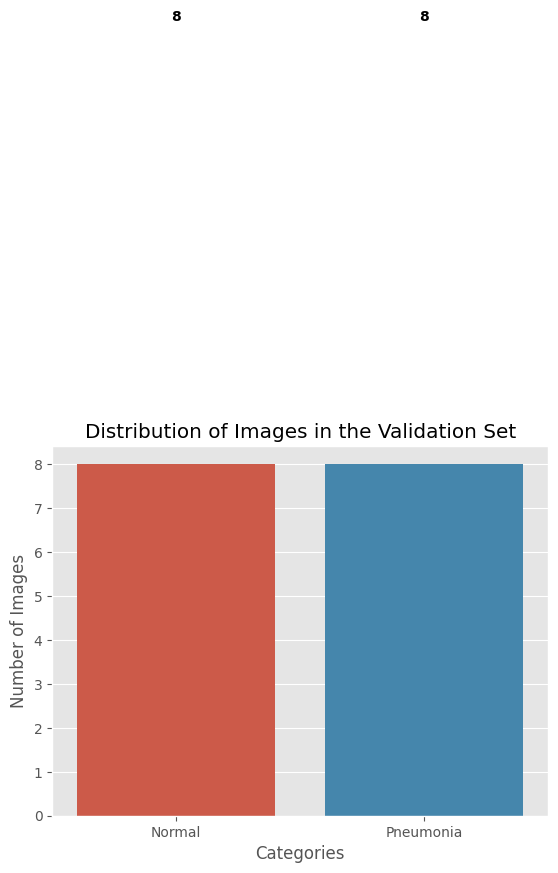

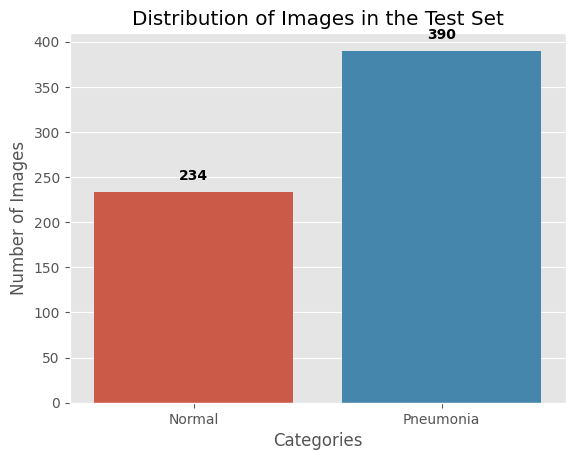

In [10]:
# Plotting the Train subset
plot_normal_pneumonia(normal=normal_train, pneumonia=pneumonia_train, subset="Train")

# Plotting the Validation subset
plot_normal_pneumonia(normal=normal_val, pneumonia=pneumonia_val, subset="Validation")

# Plotting the Test subset
plot_normal_pneumonia(normal=normal_test, pneumonia=pneumonia_test, subset="Test")

C:\Users\azizc\AppData\Local\Temp\ipykernel_4464\833273604.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


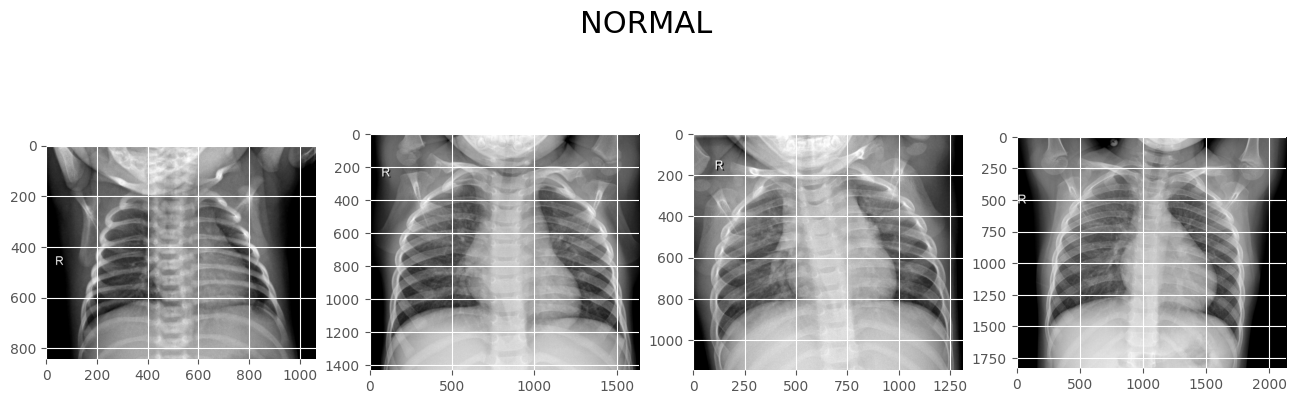

In [11]:
plot_examples(path=TRAIN_DIR)

C:\Users\azizc\AppData\Local\Temp\ipykernel_4464\833273604.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


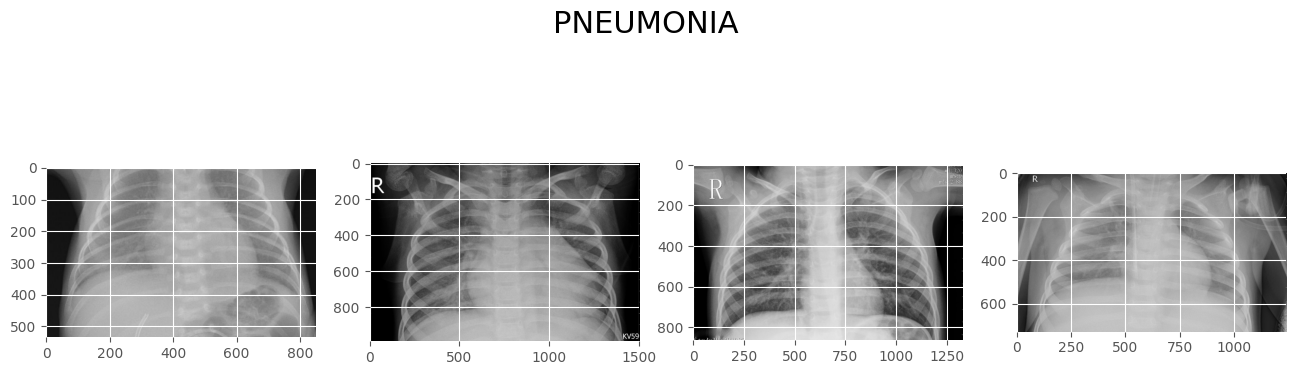

In [12]:
plot_examples(path=TRAIN_DIR, folder="PNEUMONIA/")

In [13]:
train_images_normal = os.listdir(path=TRAIN_DIR+"NORMAL/")
train_images_pneumonia = os.listdir(path=TRAIN_DIR+"PNEUMONIA/")
train_images_total = train_images_normal + train_images_pneumonia

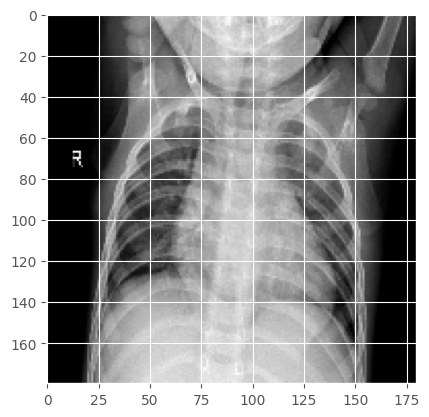

In [14]:
IMAGE_SIZE = 180
img = cv2.imread(TRAIN_DIR+"NORMAL/"+train_images_normal[60])
resized_img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
plt.imshow(resized_img)
plt.show()

In [15]:
resized_img.shape

(180, 180, 3)

In [16]:
transform = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)), #resize image
    transforms.ToTensor() # Convert image to tensor
])

In [17]:
pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
transformed_image = transform(img=pil_img)

In [18]:
transformed_image.shape

torch.Size([3, 180, 180])

In [19]:
"""All functions for preprocessing the data"""
# The function can be re-written in a way that it returns a dictionary of transformations in which each key is a unique transformation name string and the value is the transformation itself -> Future ToDo
def transform_img_size(path:str, new_size:int):
    load_img = cv2.imread(filename=path)

    transform = transforms.Compose([
    transforms.Resize(size=(new_size, new_size)), #resize image
    transforms.ToTensor() # Convert image to tensor
    ])
    
    pil_img = Image.fromarray(cv2.cvtColor(load_img, cv2.COLOR_BGR2RGB))
    transformed_image = transform(img=pil_img)

    return transformed_image    #tensor

def transform_img_v1(path:str, new_size:int):
    load_img = cv2.imread(filename=path)

    transform = transform.Compose([
        transforms.RandomRotation(30),  # Randomly rotate images in the range (degrees, 0 to 180)
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomVerticalFlip(),  # Randomly flip images vertically
        transforms.Resize(size=(new_size, new_size)), #resize image
        #transforms.RandomResizedCrop(size=(new_size, new_size)),  # Randomly crop and resize images
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),  # Randomly adjust brightness, contrast, and saturation
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    ])

    pil_img = Image.fromarray(cv2.cvtColor(load_img, cv2.COLOR_BGR2RGB))
    transformed_image = transform(img=pil_img)

    return transformed_image

def load_transformed_dataset(data_dir:str, fct_transform: Callable):
    return ImageFolder(root=data_dir, transform=fct_transform)

In [20]:
new_img = transform_img_size(path=TRAIN_DIR+"NORMAL/"+train_images_normal[60],
                   new_size=180)

In [21]:
new_img.shape

torch.Size([3, 180, 180])

In [22]:
"""Transform datastes by resizing them"""

SIZE_180 = (180, 180)
train_data_transformed = ImageFolder(root=TRAIN_DIR,
                                    transform=transforms.Compose([transforms.Resize(size=SIZE_180),transforms.ToTensor()]))


validation_data_transformed = ImageFolder(root=VALIDATION_DIR,
                                    transform=transforms.Compose([transforms.Resize(size=SIZE_180),transforms.ToTensor()]))


test_data_transformed = ImageFolder(root=TEST_DIR,
                                    transform=transforms.Compose([transforms.Resize(size=SIZE_180),transforms.ToTensor()]))


In [23]:
train_data_transformed

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: ./chest_xray/train/
    StandardTransform
Transform: Compose(
               Resize(size=(180, 180), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [24]:
batch_size = 32
train_dataloader = DataLoader(train_data_transformed, batch_size=batch_size, shuffle=True)

validation_dataloader = DataLoader(validation_data_transformed, batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(test_data_transformed, batch_size=batch_size, shuffle=True)

In [32]:
# Iterate through the DataLoader
for idx, batch in enumerate(validation_dataloader):
    images, labels = batch
    # 'images' is a batch of transformed images
    # 'labels' are the corresponding labels for each image
    # NORMAL == 0
    # PNEUMONIA == 1
    
    # Print the shape of the batch
    print("Batch of images shape:", images)
    print("Batch of labels:", labels)
    

Batch of images shape: tensor([[[[0.0431, 0.6000, 0.4039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0431, 0.6000, 0.4078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0431, 0.5961, 0.4039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0235, 0.0745,  ..., 0.0000, 0.0039, 0.0078],
          [0.0000, 0.0196, 0.0706,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0196, 0.0706,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0431, 0.6000, 0.4039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0431, 0.6000, 0.4078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0431, 0.5961, 0.4039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0235, 0.0745,  ..., 0.0000, 0.0039, 0.0078],
          [0.0000, 0.0196, 0.0706,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0196, 0.0706,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0431, 0.6000, 0.4039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0431, 0.6000, 0.4078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0431, 

In [55]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNModel, self).__init__()

        """self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(123904,num_classes)
        )
    
    def forward(self, xb):
        return self.network(xb)"""
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 90 * 90, 64)
        self.fc2 = nn.Linear(64, num_classes)  # num_classes is the number of output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
        

In [56]:
#from CustomCNN import CNNModel
nb_classes = 2
model = CNNModel(num_classes=nb_classes)
summary(model, input_size=(3, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 180, 180]             896
              ReLU-2         [-1, 32, 180, 180]               0
            Conv2d-3         [-1, 64, 180, 180]          18,496
              ReLU-4         [-1, 64, 180, 180]               0
         MaxPool2d-5           [-1, 64, 90, 90]               0
            Conv2d-6          [-1, 128, 90, 90]          73,856
              ReLU-7          [-1, 128, 90, 90]               0
            Conv2d-8          [-1, 128, 90, 90]         147,584
              ReLU-9          [-1, 128, 90, 90]               0
        MaxPool2d-10          [-1, 128, 45, 45]               0
           Conv2d-11          [-1, 256, 45, 45]         295,168
             ReLU-12          [-1, 256, 45, 45]               0
           Conv2d-13          [-1, 256, 45, 45]         590,080
             ReLU-14          [-1, 256,

In [57]:
lr = 0.001
wd = 0.005
momentum = 0.9
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=momentum)  

total_step = len(train_dataloader)

In [58]:
from tqdm import tqdm
loss_list = []
for epoch in range(num_epochs):
    loss_epoch=0.0
	#Load in the data in batches using the train_loader object
    for idx, (images, labels) in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_epoch += loss.item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Calculate average loss for the epoch
    average_loss = loss_epoch / len(train_dataloader)
    loss_list.append(average_loss)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, average_loss))

Epoch [1/5], Loss: 0.5800


Epoch [2/5], Loss: 0.5712


KeyboardInterrupt: 

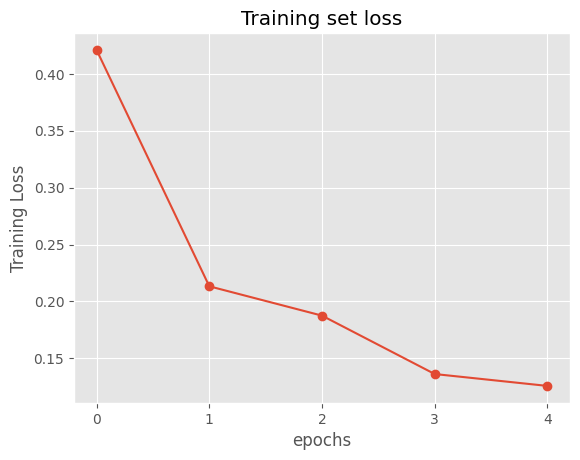

In [99]:
# Plot with matplotlib
def plot_metric_epochs(metric_values:list, x_label_name="epochs" , y_label_name="Training Loss", title="Training set loss") -> None:
  epochs = list(range(len(metric_values)))
  plt.plot(epochs, metric_values,  "-o")
  plt.xticks(epochs)
  plt.xlabel(x_label_name)
  plt.ylabel(y_label_name)
  plt.title(title)
  plt.show()


plot_metric_epochs(metric_values=loss_list)

In [101]:
from sklearn.metrics import classification_report
#Testing phase
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    for images, labels in tqdm(test_dataloader, desc='Testing Progress', leave=False):
        all_labels += labels.tolist()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_list = predicted.cpu().tolist()
        all_predictions += predicted_list
        #print(f"Predicted -> {predicted}")
        #total += labels.size(0)
        #print(f"Total -> {total}")
        correct += (predicted == labels).sum().item()
    n, p, nb_total = get_number_of_images(TEST_DIR)
    #print('Accuracy of the network on the {} train images: {} %'.format(total, 100 * correct / total))
    print(f'Accuracy of the network on the {nb_total} test images: {100 * correct / nb_total:.2f}%')
    #print(f"PREDICTIONS == {all_predictions}")
    #print(f"LABELS == {all_labels}")

    print(f"FINAL REPORT:\n{classification_report(y_true=all_labels, y_pred=all_predictions)}")



Testing Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Accuracy of the network on the 624 test images: 71.96%
FINAL REPORT:
              precision    recall  f1-score   support

           0       0.93      0.27      0.42       234
           1       0.69      0.99      0.81       390

    accuracy                           0.72       624
   macro avg       0.81      0.63      0.62       624
weighted avg       0.78      0.72      0.67       624



In [102]:
summary(model, input_size=(3, 180, 180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 180, 180]             448
              ReLU-2         [-1, 16, 180, 180]               0
         MaxPool2d-3           [-1, 16, 90, 90]               0
            Linear-4                   [-1, 64]       8,294,464
              ReLU-5                   [-1, 64]               0
            Linear-6                    [-1, 2]             130
Total params: 8,295,042
Trainable params: 8,295,042
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.37
Forward/backward pass size (MB): 8.90
Params size (MB): 31.64
Estimated Total Size (MB): 40.91
----------------------------------------------------------------


In [88]:
# Save the trained model
torch.save(model.state_dict(), 'trained_model_32_resize_long.pth')

In [93]:
# Create an instance of your model
loaded_model = CNNModel(num_classes=2)

# Load the trained parameters into the model
loaded_model.load_state_dict(torch.load('trained_model_32_resize.pth'))
loaded_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    for images, labels in tqdm(validation_dataloader, desc='Testing Progress', leave=False):
        all_labels += labels.tolist()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_list = predicted.cpu().tolist()
        all_predictions += predicted_list
        #print(f"Predicted -> {predicted}")
        #total += labels.size(0)
        #print(f"Total -> {total}")
        correct += (predicted == labels).sum().item()
    n, p, nb_total = get_number_of_images(TEST_DIR)
    #print('Accuracy of the network on the {} train images: {} %'.format(total, 100 * correct / total))
    print(f'Accuracy of the network on the {nb_total} test images: {100 * correct / nb_total:.2f}%')
    #print(f"PREDICTIONS == {all_predictions}")
    #print(f"LABELS == {all_labels}")

    print(f"FINAL REPORT:\n{classification_report(y_true=all_labels, y_pred=all_predictions)}")


Accuracy of the network on the 624 test images: 1.76%
FINAL REPORT:
              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.62      1.00      0.76         8

    accuracy                           0.69        16
   macro avg       0.81      0.69      0.65        16
weighted avg       0.81      0.69      0.65        16



In [92]:
for images, labels in tqdm(validation_dataloader, desc='Testing Progress', leave=False):
        all_labels += labels.tolist()
        images = images.to(device)
        labels = labels.to(device)
        outputs = loaded_model(images)
        _, predicted = torch.max(outputs.data, 1)